In [2]:
from math import exp, sqrt, log
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

from dictances import jensen_shannon
import matplotlib.pyplot as plt
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

from ref.Diffusion_Maps import diffusionMapping
from ref.Shir import utils as shir_utils
from utils import min_max_scaler, calc_mean_std, flatten, norm_by_dist_type, calculate_distance
from main import execute_distance_func, calc_dist, export_heatmaps, k_medoids_features, return_best_features_by_kmeans



ImportError: cannot import name 'k_medoids_features' from 'main' (C:\Users\OmerHedvat\PycharmProjects\Thesis\main.py)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Data From - https://archive.ics.uci.edu/ml/datasets/glass+identification

In [2]:
pd.set_option('display.max_columns', None)
df_glass = pd.read_csv('data/glass.csv')
df_glass.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_glass.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [4]:
df_glass['label'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: label, dtype: int64

# Feature HeatMaps w/ distance

# Feature HeatMaps w/ distance normalization

In [5]:
features = df_glass.columns.tolist()[:-1]
df_norm = min_max_scaler(df_glass, features)

export_heatmaps(df_norm, features, 'wasserstein_dist', 'hellinger_dist')

export_heatmaps(df_norm, features, 'wasserstein_dist', 'jensen_shannon_dist')

export_heatmaps(df_norm, features, 'jm_dist', 'hellinger_dist')

export_heatmaps(df_norm, features, 'bhattacharyya_dist', 'hellinger_dist')

In [7]:
def k_medoids_features(coordinates, k):
    #calc KMediod to get to centers
    coordinates = coordinates.T
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(coordinates)
    centers = kmedoids.cluster_centers_
    
    #search for the features index
    r_features = []
    for i , v in enumerate(coordinates):
        if v in centers:
            r_features.append(i)
    return r_features   

In [8]:
df_dists_wasser, dist_dict_wasser = calc_dist('wasserstein_dist', df_norm, 'label')
df_dists_wasser.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.0,0.057404,0.039554,0.077971,0.088249,0.074416,0.057404,0.0,0.044238,0.104490,0.119250,0.065950,0.039554,0.044238,0.0,0.091602,0.090029,0.049388,0.077971,0.104490,0.091602,0.0,0.077996,0.106090,0.088249,0.119250,0.090029,0.077996,0.0,0.101465,0.074416,0.065950,0.049388,0.106090,0.101465,0.0
1,0.0,0.023715,0.038668,0.062345,0.211185,0.186290,0.023715,0.0,0.051571,0.045014,0.230820,0.200054,0.038668,0.051571,0.0,0.091634,0.181896,0.153307,0.062345,0.045014,0.091634,0.0,0.273530,0.242763,0.211185,0.230820,0.181896,0.273530,0.0,0.066984,0.186290,0.200054,0.153307,0.242763,0.066984,0.0
2,0.0,0.126256,0.017595,0.618838,0.500417,0.671303,0.126256,0.0,0.124980,0.496272,0.377851,0.548737,0.017595,0.124980,0.0,0.616856,0.498435,0.669322,0.618838,0.496272,0.616856,0.0,0.127672,0.093866,0.500417,0.377851,0.498435,0.127672,0.0,0.210361,0.671303,0.548737,0.669322,0.093866,0.210361,0.0
3,0.0,0.076106,0.033260,0.271025,0.103264,0.298723,0.076106,0.0,0.064644,0.194918,0.062861,0.222617,0.033260,0.064644,0.0,0.259399,0.085476,0.287097,0.271025,0.194918,0.259399,0.0,0.207844,0.110480,0.103264,0.062861,0.085476,0.207844,0.0,0.235543,0.298723,0.222617,0.287097,0.110480,0.235543,0.0
4,0.0,0.031805,0.038436,0.097747,0.117018,0.097753,0.031805,0.0,0.053443,0.089486,0.113343,0.082499,0.038436,0.053443,0.0,0.110601,0.143207,0.128792,0.097747,0.089486,0.110601,0.0,0.157906,0.117947,0.117018,0.113343,0.143207,0.157906,0.0,0.121326,0.097753,0.082499,0.128792,0.117947,0.121326,0.0
5,0.0,0.012137,0.006609,0.168052,0.072050,0.074282,0.012137,0.0,0.018451,0.161298,0.083905,0.080751,0.006609,0.018451,0.0,0.173010,0.065454,0.069815,0.168052,0.161298,0.173010,0.0,0.236715,0.184352,0.072050,0.083905,0.065454,0.236715,0.0,0.052363,0.074282,0.080751,0.069815,0.184352,0.052363,0.0
6,0.0,0.072304,0.015714,0.191095,0.094874,0.030739,0.072304,0.0,0.086486,0.184064,0.112750,0.095329,0.015714,0.086486,0.0,0.200945,0.104672,0.029208,0.191095,0.184064,0.200945,0.0,0.099355,0.185745,0.094874,0.112750,0.104672,0.099355,0.0,0.098420,0.030739,0.095329,0.029208,0.185745,0.098420,0.0
7,0.0,0.012221,0.003663,0.055549,0.004036,0.326122,0.012221,0.0,0.013809,0.051565,0.015957,0.316458,0.003663,0.013809,0.0,0.056784,0.002801,0.327358,0.055549,0.051565,0.056784,0.0,0.059585,0.283929,0.004036,0.015957,0.002801,0.059585,0.0,0.330159,0.326122,0.316458,0.327358,0.283929,0.330159,0.0
8,0.0,0.044582,0.027072,0.092502,0.111765,0.085396,0.044582,0.0,0.055940,0.110264,0.156347,0.129978,0.027072,0.055940,0.0,0.066188,0.111880,0.085511,0.092502,0.110264,0.066188,0.0,0.119155,0.097779,0.111765,0.156347,0.111880,0.119155,0.0,0.026369,0.085396,0.129978,0.085511,0.097779,0.026369,0.0


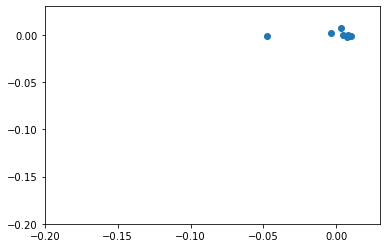

In [32]:
eps_type='maxmin'#mean' #or maxmin
alpha=1
vec_wasser, egs_wasser, coordinates_wasser, dataList_wasser, epsilon_wasser = (
diffusionMapping(df_dists_wasser, alpha, eps_type, 8, 1, dim=2)
)

plt.xlim(-0.2, 0.03)
plt.ylim(-0.2, 0.03)
plt.scatter(coordinates_wasser[0], coordinates_wasser[1])

In [47]:
coordinates_wasser[0]

array([ 0.01055413,  0.00443403, -0.04748152, -0.00369598,  0.00784615,
        0.00850815,  0.00750621,  0.00348755,  0.00885972])

In [51]:
k = 4
features_rank = np.argsort(X[0])

In [55]:
features_rank

array([2, 3, 7, 1, 6, 4, 5, 8, 0], dtype=int64)

In [19]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit(coordinates_wasser.T).labels_

In [20]:
labels

array([2, 2, 1, 0, 2, 2, 2, 3, 2])

In [66]:
def return_best_features_by_kmeans(coordinates, k):
    features_rank = np.argsort(coordinates[0])
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit(coordinates.T).labels_        
    best_features = []
    selected_cetroids = []
    for idx in features_rank:
        if labels[idx] not in selected_cetroids:
            selected_cetroids.append(labels[idx])
            best_features.append(idx)       
    return best_features, labels, features_rank

In [68]:
best_features, labels, features_rank = return_best_features_by_kmeans(coordinates_wasser, 3)
print(f'{best_features=}')
print(f'{labels=}')
print(f'{features_rank=}')

best_features=[2, 3, 1]
labels=array([2, 2, 1, 0, 2, 2, 2, 0, 2])
features_rank=array([2, 3, 7, 1, 6, 4, 5, 8, 0], dtype=int64)


In [11]:
print(k_medoids_features(coordinates_wasser, k))

NameError: name 'KMedoids' is not defined

In [31]:
df_coordinates_wasser = pd.DataFrame(data=coordinates_wasser).T
df_coordinates_wasser.head(10)

,0,1
0,-0.047482,-0.002070
1,-0.003696,-0.001527
2,0.003488,-0.001467
3,0.004434,-0.001144
4,0.007506,-0.000949
5,0.007846,-0.000774
6,0.008508,-0.000439
7,0.008860,0.001760
8,0.010554,0.006610


In [ ]:
dists = []
for index1, row1 in df_coordinates_wasser.iterrows():
    dists2 = [calculate_distance(row1, row2) for index2, row2 in df_coordinates_wasser.iterrows()]
    dists.append(dists2)
df_DM_dists_wasser = pd.DataFrame(dists)
df_DM_dists_wasser.head(10)

In [ ]:
df_dists_jm, dist_dict_jm = calc_dist('jm_dist', df_norm, 'label')
df_dists_jm.head(10)

#JM

In [ ]:
eps_type='maxmin'#mean' #or maxmin
alpha=1
vec_jm, egs_jm, coordinates_jm, dataList_jm, epsilon_jm = diffusionMapping(df_dists_jm, alpha, eps_type, 4, 1, dim=2)

In [ ]:
k = 4

print(rank_features(coordinates_jm[0],k))

In [ ]:
print(k_medoids_features(coordinates_jm, k))

In [ ]:
plt.xlim(-0.5, 0.7)
plt.ylim(-0.5, 0.7)
plt.scatter(coordinates_jm[0], coordinates_jm[1])

In [ ]:
df_coordinates_jm = pd.DataFrame(data=coordinates_jm).T
df_coordinates_jm.head(10)

In [ ]:
dists = []
for index1, row1 in df_coordinates_jm.iterrows():
    dists2 = [calculate_distance(row1, row2) for index2, row2 in df_coordinates_jm.iterrows()]
    dists.append(dists2)
df_DM_dists_jm = pd.DataFrame(dists)
df_DM_dists_jm.head(10)

### PreProcess
Normalize the data

### Add Heatmap for each feature + heat scala

### 1st step - Embedding 
Over the feature matrix (6x6 / 4x4 / 3x3) - CNN
Over the feature row (1x36) - AutoEncoder
Over the flatenned matrix -  Random Projections / DM

### 2nd step - Diffusion Maps
DM over the encoded matrix (9x36-->9x2 for example)
DM from https://datafold-dev.gitlab.io/datafold/intro.html

### 3rd step - plot

